In [1]:
# Importaciones iniciales
import sys
from collections import OrderedDict

from mne import create_info, concatenate_raws, preprocessing
from mne.io import RawArray
from mne.channels import read_montage

import pandas as pd
import numpy as np

from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt

# importar utilidades de muse-lsl
sys.path.append('../muse')
import utils

%matplotlib inline

## Cargar datos desde muse
Se pueden leer datos del dispositivo y guardarlos en un .csv con la utilidad de `lsl-record.py.` 

Ejemplo: `python stimulus_presentation/generate_Visual_P300.py & python lsl-record.py -d 60`

Un problema de esta utilidad es que espera un canal de eventos (markers). En este ejemplo dicho canal es provisto por generate_Visual_P300.py que es un evento propio del repositorio original

## Cargar datos CSV para entrenamiento
muse-lsl tiene una utilidad propia para cargar los datos de un .csv. Para utilizarla primero se deben guardar los datos bajo el directorio "data/<nombre>" e invocar la función utils.load_data(). La misma leerá todos los .csv bajo el directorio pasado como argumento y devolverá un objeto del tipo mne.raw.

In [2]:
# Carga los datos desde una carpeta. Espera archivos CSV
subject = 1
session = 1

raw_train = utils.load_data('train', sfreq=256., 
                      subject_nb=subject, session_nb=session, 
                      ch_ind=[0, 1, 2, 3])
#raw.info

Creating RawArray with float64 data, n_channels=5, n_times=7692
    Range : 0 ... 7691 =      0.000 ...    30.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=7692
    Range : 0 ... 7691 =      0.000 ...    30.043 secs
Ready.


In [3]:
# explorar los datos
%matplotlib auto
raw_train.plot(butterfly=True, group_by='position', show=True);

Using matplotlib backend: Qt4Agg


/home/default/.conda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/default/.conda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/default/.conda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Effective window size : 8.000 (s)


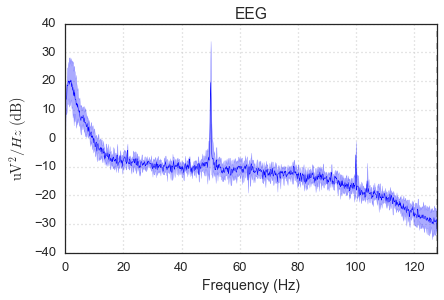

In [4]:
#ver espectro de frecuencia de los EEG
%matplotlib inline
raw_train.plot_psd(color=(0, 0, 1),
          show=False, average=True);

Como puede verse, existe un pico en 50Hz y un armónico en 100Hz.
## Filtrado

Para eliminar información que no necesitamos, filtramos entre 1 y 40Hz

Effective window size : 8.000 (s)
Setting up band-pass filter from 1 - 40 Hz
Setting up band-pass filter from 1 - 40 Hz
Effective window size : 8.000 (s)


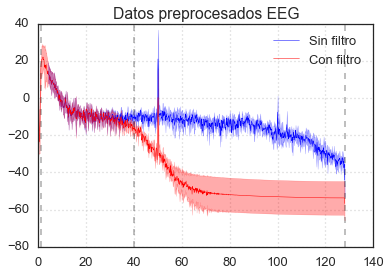

In [3]:
# filtro a 40Hz y grafico el espectro resultante
plt.figure()
ax = plt.axes()
raw_train.plot_psd(tmin=0.0, tmax=20.0, fmin=4.0, fmax=128.0, n_fft=2048,
           n_jobs=1, proj=False, ax=ax, color=(0, 0, 1),
          show=False, average=True)


# And now do the same with SSP + notch filtering
# Pick all channels for notch since the SSP projection mixes channels together
#filteredRaw  = raw.notch_filter(np.arange(50, 128, 50), n_jobs=1, fir_design='firwin')
filteredRaw = raw_train.filter(1,40, method='iir', skip_by_annotation='edge')
filteredRaw.plot_psd(tmin=0.0, tmax=20.0, fmin=0.0, fmax=128.0, n_fft=2048,
           n_jobs=1, proj=False, ax=ax, color=(1, 0, 0),
           show=False, average=True)

ax.set_title('Datos preprocesados EEG')
plt.legend(ax.lines[::3], ['Sin filtro', 'Con filtro'])


## Epoching
Se dividen los registros en Epochs entre -100ms y 800ms luego del evento. No se hace corrección a la baseline y NO se rechazan los eventos mayores a 100uV (mayormente parpadeos) porque es lo que se quiere clasificar.

In [7]:
# descubrir eventos desde el EEG crudo
from mne import Epochs, find_events

events = find_events(raw_train, output='offset')
#elimino el último porque puede quedar cortado
events = events[:-1] 
event_id = {'No parpadeo':1,'Parpadeo': 2}
# start of each epoch (400ms before the trigger)
tmin = -0.4    
# end of each epoch (800ms after the trigger)
tmax = 0.8
#normalmente la función de abajo toma otro comando reject = {eeg=some_value} para eliminar los epochs con ruido.
epochs_train = Epochs(raw_train, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True, verbose=True)#, picks=[0,1,2,3])
# incidentalmente, existe una función que encuentra automáticamente los artefactos del parpadeo
# pero requiere canales extra que indiquen cuando fue el artefacto.
#eog_events = preprocessing.find_eog_events(raw)

31 events found
Events id: [1 2]
30 matching events found
0 projection items activated
Loading data for 30 events and 308 original time points ...
1 bad epochs dropped


Using matplotlib backend: Qt4Agg
Dropped 0 epochs
Channels marked as bad: []


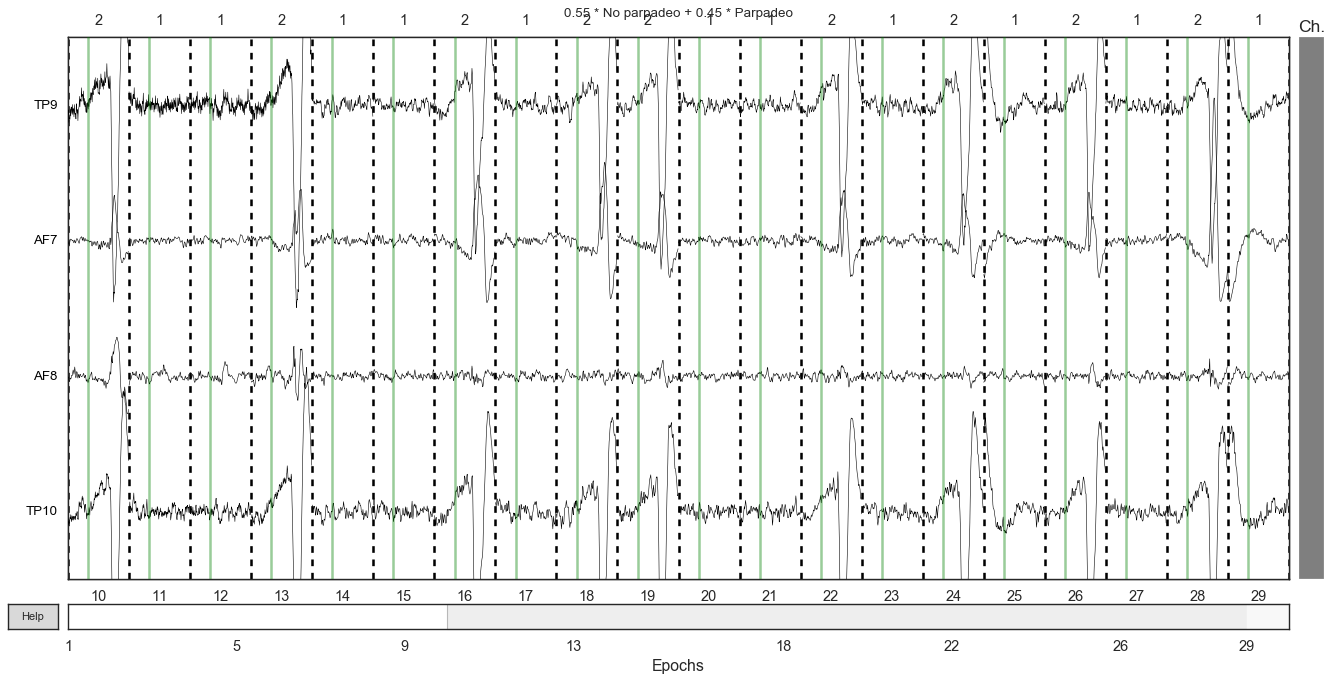

In [10]:
#muestra los epochs. La presentación es interactiva y al hacer click sobre el Epoch, se los marca como malos
%matplotlib auto 
# block=True significa que la ejecución del programa se bloquea hasta que se cierre la figura
# útil si se quiere marcar canales on the fly.
epochs_train.plot(block=True)

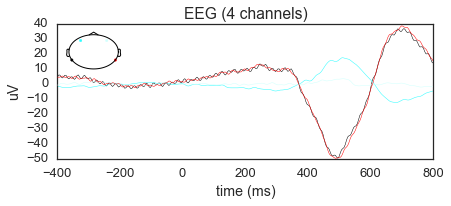

In [8]:
#ver promedios de cada canal
%matplotlib inline
epochs_train.average().plot(spatial_colors=True);

En la figura anterior se muestra el promedio de los Epochs para los cuatro canales. Este sería el "patron" a detectar si sólo trabajamos en el dominio del tiempo. Se observa que el patrón bastante evidente. En la figura donde se ven los valores instantáneos de los Epochs se puede apreciar que los identificados como 1 y 2 no presentan la misma figura que los otros. Habrá pues que excluirlos.

In [11]:
# borrar los dos primeros, 
epochs_train.drop([24,28])

Dropped 2 epochs


<Epochs  |  n_events : 27 (all good), tmin : -0.3984375 (s), tmax : 0.80078125 (s), baseline : None, ~346 kB, data loaded,
 'No parpadeo': 14, 'Parpadeo': 13>

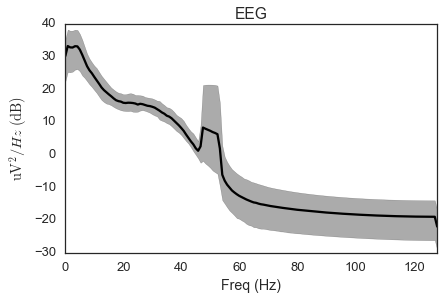

In [12]:
epochs_train.plot_psd(area_mode='range', tmax=60.0, show=False);
#raw.plot_projs_topomap()

#  Clasificación

En el contexto de EEG, al aprendizaje supervisado se le llama _decoding_ o también _multivariate pattern analysis (MPVA)_ 


In [13]:
#imports
from mne import io, EvokedArray
from mne.datasets import sample
from mne.decoding import Vectorizer, get_coef

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split


# import a linear classifier from mne.decoding
from mne.decoding import LinearModel

/home/default/.conda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
labels = epochs_train.events[:, -1]

## Regresión logística

En primer instancia se deben escalar los datos. Al aplicar el scaler, el dataset queda con media cero y desviación estandar unitaria. Esto es necesario porque muchos métodos de ML asumen que así se presentarán los datos.

Luego see dividen los datos en dos sets, de entrenamiento y de pruebas. Con el segundo se verificarán los resultados del primero.

El clasificador usado en esta primera instancia es uno basado en regresión logística, como tal es uno de lo más básicos.


In [35]:
scaler = StandardScaler()

#reshape data
eeg_data_train = epochs_train.get_data().reshape(len(labels), -1)
# fit the classifier on MEG data
X = scaler.fit_transform(eeg_data_train)

y = epochs_train.events[:, 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

y_train

array([2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2])

In [36]:
clf = LogisticRegression()

# create a linear model with LogisticRegression
model = LinearModel(clf)

model.fit(X_train, y_train)

LinearModel(model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))

Vemos que al evaluar las predicciones con el conjunto de datos reservados para pruebas, el clasificador tiene una precisión cercana o igual al 100%. No olvidemos que trabajamos con un tipo de evento (parpadeo) que es fácilmente reconocible en el EEG y que genera una deformación en las señales apreciables. Seguramente la exactitud no será tan alta con otro tipo de eventos.

In [37]:
clf.score(X_test, y_test)

1.0

Podemos graficar la intensidad de la distribución espacial de las señales en el dominio del tiempo con la siguiente función:

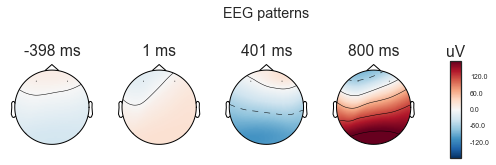

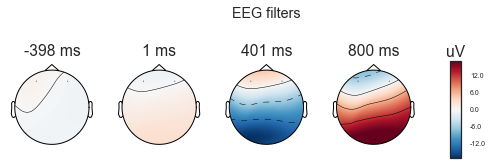

In [38]:
# Extract and plot spatial filters and spatial patterns
for name, coef in (('patterns', model.patterns_), ('filters', model.filters_)):
    # We fitted the linear model onto Z-scored data. To make the filters
    # interpretable, we must reverse this normalization step
    coef = scaler.inverse_transform([coef])[0]

    # The data was vectorized to fit a single model across all time points and
    # all channels. We thus reshape it:
    coef = coef.reshape(len(epochs_train.ch_names), -1)

    # Plot
    evoked = EvokedArray(coef, epochs_train.info, tmin=epochs_train.tmin)
    evoked.plot_topomap(title='EEG %s' % name)


Esto que viene a continuación es lo mismo pero de otra manera. Notar que los gráficos producidos son idénticos. Estaría bueno estudiar si hay alguna diferencia real.

In [27]:
# manera alternativa de obtener el dataset, y de construir un pipeline
X = epochs_train.pick_types(meg=False, eeg=True)
y = epochs_train.events[:, 2]

# Define a unique pipeline to sequentially:
clf = make_pipeline(
    Vectorizer(),                       # 1) vectorize across time and channels
    StandardScaler(),                   # 2) normalize features across trials
    LinearModel(LogisticRegression()))  # 3) fits a logistic regression
clf.fit(X, y)


Pipeline(steps=[('vectorizer', <mne.decoding.transformer.Vectorizer object at 0x7f187c068110>), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearmodel', LinearModel(model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)))])

## Cross validation

Un problema que surge de optimizar hiperparámetros es que, si se usa el mismo test set y train set, se optimiza el modelo para un test set en particular y hay sobreajuste.

Una solución es usar _cross-validation_ (CV) con lo cual se reserva un test set para evaluar al clasificador, pero el train set se divide ahora k-subsets o k-folds. El modelo es entonces entrenado con (k-1) subsets y el restante se usa para validarlo. El proceso se puede repetir varias veces, con divisiones distintas de los subsets, y de esta manera obtener un promedio de la clasificación.



In [46]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 1.    1.    0.75  1.    1.  ]
Accuracy: 0.95 (+/- 0.20)


Como se observa, en 5 ejecuciones, el clasificador obtuvo un porcentaje de éxito = 100% en 4 casos.

# TODO
- TODO mne.set_eeg_reference (incluir referencia para mejorar SNR?)
- TODO ICA Preprocessing for artifact supression
- TODO Epoching on the fly
- TODO http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [27]:
X1 = epochs_train.pick_types(meg=False, eeg=True)
y1 = epochs_train.events[:, 2]

# Define a unique pipeline to sequentially:
clf = make_pipeline(
    Vectorizer(),                       # 1) vectorize across time and channels
    StandardScaler(),                   # 2) normalize features across trials
    DecisionTreeClassifier())  # 3) fits a logistic regression
clf.fit(X, y)

Pipeline(steps=[('vectorizer', <mne.decoding.transformer.Vectorizer object at 0x7f00f4106e50>), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, m...it=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])

In [28]:
y_predicted = clf.predict(X_test)

In [29]:
y_test


array([2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2])

In [30]:
y_predicted

array([2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2])